##### Load scraped data from csv file

In [48]:
import pandas as pd
import scraper
import postal_codes_scraper
import importlib
from sklearn.pipeline import Pipeline

importlib.reload(scraper)
importlib.reload(postal_codes_scraper)

<module 'postal_codes_scraper' from 'c:\\Users\\USER\\Documents\\HouseSigma Scraper\\housesigma-scraper\\postal_codes_scraper.py'>

In [19]:
# Load the DataFrame from the CSV file
input_df = pd.read_csv('filtered_sold_data.csv')
input_df = input_df.drop_duplicates().reset_index(drop=True)

print(input_df.shape)
print(input_df.columns)
print("\n ===================== \n")
print(input_df.dtypes)
print("\n ===================== \n")
print(input_df.head())

(764, 10)
Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms',
       'Bathrooms', 'Postal Code', 'Listing URL', 'Bedroom Category',
       'Postal Code Area'],
      dtype='object')


Asking Price        float64
Sold Price          float64
Address              object
Unit Type            object
Bedrooms             object
Bathrooms             int64
Postal Code          object
Listing URL          object
Bedroom Category     object
Postal Code Area     object
dtype: object


   Asking Price  Sold Price  \
0      998000.0    975000.0   
1     1259000.0   1349000.0   
2     3599900.0   3250000.0   
3      825000.0    780000.0   
4      559000.0    529000.0   

                                             Address        Unit Type  \
0   623 - 88 Colgate Ave , Toronto - South Riverdale        Condo Apt   
1  84A Aylesworth Ave , Scarborough - Birchcliffe...         Detached   
2            501 Avonwood Dr , Mississauga - Mineola         Detached   
3  314 - 199 Pine Gr

##### Extract maintenance fees from urls

In [20]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

print("🔄 Reinitializing WebDriver...")

options = webdriver.ChromeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ✅ Open HouseSigma for manual login
driver.get("https://housesigma.com")
input("🔑 Press Enter after logging in manually...")  # ⬅️ Login manually, then press Enter

input_extracted_data = scraper.process_with_progress(input_df, driver, progress_interval=100)

# ✅ Convert the extracted dictionary output into a DataFrame
input_extracted_df = input_extracted_data.apply(pd.Series)

# ✅ Close the browser after processing all listings
driver.quit()
print(input_extracted_df.shape)
print("\n✅ All listings processed. Browser closed.")

🔄 Reinitializing WebDriver...
🚀 Processing row 1/764
🚀 Processing row 101/764
🚀 Processing row 201/764
🚀 Processing row 301/764
🚀 Processing row 401/764
🚀 Processing row 501/764
🚀 Processing row 601/764
🚀 Processing row 701/764
🚀 Processing row 764/764
(764, 3)

✅ All listings processed. Browser closed.


In [21]:
# Save the DataFrame to a CSV file
input_extracted_df.to_csv('input_extracted_data.csv', index=False)

# Print a confirmation message
print("DataFrame has been saved to 'input_extracted_data.csv'")

DataFrame has been saved to 'input_extracted_data.csv'


In [26]:
# Load the DataFrame from the CSV file
input_extracted_df = pd.read_csv('input_extracted_data.csv')

print(input_extracted_df.shape)
print("\n ===================== \n")

# Extract numeric values from the 'Maintenance Fees' column
input_extracted_df['Maintenance Fees'] = (
    input_extracted_df['Maintenance Fees']
    .str.replace(r'[^\d.]', '', regex=True)  # Remove non-numeric characters
    .replace('', '0')  # Replace empty strings with '0'
    .astype(float)  # Convert to float
    .fillna(0)  # Replace NaN with 0
)

# Print the first few rows to verify
print(input_extracted_df.head())

(764, 3)


  Sold Days Ago  Maintenance Fees  \
0             5             708.0   
1            11               0.0   
2            11               0.0   
3            11             414.0   
4            12             728.0   

                                    Unit Description  
0  Inviting you to Suite 623 at the exceptional S...  
1  Luxury, detached custom-built 4 bed + 5 bths +...  
2  Where luxury is sprinkled with a traditional m...  
3  Don't Miss This Exceptional Opportunity To Own...  
4  Welcome to Tridel-Built 'Qwest' at Prime Locat...  


##### Merge input data and extracted data (sold days ago values, maintenance fees, unit description)

In [33]:
# Concatenate the DataFrames along the columns axis
merged_df = pd.concat([input_df, input_extracted_df], axis=1)

merged_df['Sold Days Ago'].fillna(0, inplace=True)

# Print the first few rows to verify
print(merged_df.shape)
print("\n ===================== \n")
print(merged_df.head())

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)

# Print a confirmation message
print("Merged DataFrame has been saved to 'merged_data.csv'")

(764, 13)


   Asking Price  Sold Price  \
0      998000.0    975000.0   
1     1259000.0   1349000.0   
2     3599900.0   3250000.0   
3      825000.0    780000.0   
4      559000.0    529000.0   

                                                     Address        Unit Type  \
0           623 - 88 Colgate Ave , Toronto - South Riverdale        Condo Apt   
1   84A Aylesworth Ave , Scarborough - Birchcliffe-Cliffside         Detached   
2                    501 Avonwood Dr , Mississauga - Mineola         Detached   
3        314 - 199 Pine Grove Rd , Vaughan - East Woodbridge  Condo Townhouse   
4  517 - 168 Simcoe St , Toronto - Waterfront Communities C1        Condo Apt   

  Bedrooms  Bathrooms Postal Code  \
0        2          2      M4M0A6   
1        4          5      M1N2J6   
2        4          4      L5G1Y8   
3        2          2      L4L0H8   
4        1          1      M5H4C9   

                                                                                   Listing 

C:\Users\USER\AppData\Local\Temp\ipykernel_4104\1331898352.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Sold Days Ago'].fillna(0, inplace=True)


##### Check maintenance fees values for condo units

In [34]:
# Filter the DataFrame for rows where 'Unit Type' contains 'Condo' (case-insensitive) and 'Maintenance Fees' are 0
condo_zero_fees = merged_df[(merged_df['Unit Type'].str.contains('condo', case=False, na=False)) & (merged_df['Maintenance Fees'] == 0)]

# Print the number of rows that match the criteria
print(f"Number of rows where 'Unit Type' contains 'condo' and 'Maintenance Fees' are 0: {condo_zero_fees.shape[0]}")

# Optionally, print the first few rows to verify
pd.set_option('display.max_colwidth', None)
print(condo_zero_fees.head())

Number of rows where 'Unit Type' contains 'condo' and 'Maintenance Fees' are 0: 3
     Asking Price  Sold Price  \
315      698000.0    680000.0   
509      695000.0    640000.0   
590      599000.0    525000.0   

                                                         Address  Unit Type  \
315       608 - 8 Eglinton Ave E , Toronto - Mount Pleasant West  Condo Apt   
509  809 - 77 Harbour Sq W , Toronto - Waterfront Communities C1  Condo Apt   
590     3007 - 50 Charles St E , Toronto - Church-Yonge Corridor  Condo Apt   

    Bedrooms  Bathrooms Postal Code  \
315        2          2      M4P0C1   
509        1          1      M5J2S2   
590        1          1      M4Y0C3   

                                                                                   Listing URL  \
315  https://housesigma.com/on/toronto-real-estate/608-8-eglinton-ave-e/home/damgL7AqBJV7Z1MW/   
509   https://housesigma.com/on/toronto-real-estate/809-77-harbour-sq-w/home/weQp5yOoorvyd0ZE/   
590  https://hous

##### If there are only several rows missing maintenace fees, can enter them manually

In [35]:
updates = [
    (315, 877.00),
    (509, 974.00),
    (590, 522.00)
]

for idx, fee in updates:
    merged_df.loc[idx, 'Maintenance Fees'] = fee

In [36]:
merged_df.to_csv("merged_data.csv", index=False)

##### Create more features for predictive model

In [3]:
# Load the merged DataFrame from the CSV file
merged_df = pd.read_csv('merged_data.csv')

print(merged_df.columns)
print("\n ===================== \n")
print(len(merged_df['Postal Code Area'].unique()))

Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms',
       'Bathrooms', 'Postal Code', 'Listing URL', 'Bedroom Category',
       'Postal Code Area', 'Sold Days Ago', 'Maintenance Fees',
       'Unit Description'],
      dtype='object')


116


##### Determine Postal Code Area coordinates

In [4]:
postal_codes_scraper.get_lat_lon_from_geonames("m4m")

(43.651, -79.34)

In [5]:
import pgeocode

# Initialize the pgeocode Nominatim for Canada
nomi = pgeocode.Nominatim('ca')

# Suppose you have a list of postal codes
postal_codes = ["M2R", "M4M", "M5R", "M3C"]

# Option 1: Query them in a simple loop
for pc in postal_codes:
    result = nomi.query_postal_code(pc)
    print(f"{pc} -> Lat: {result.latitude}, Lon: {result.longitude}, Place: {result.place_name}, Province: {result.state_name}")

M2R -> Lat: 43.7786, Lon: -79.445, Place: Willowdale West, Province: Ontario
M4M -> Lat: 43.6561, Lon: -79.3406, Place: East Toronto (Studio District), Province: Ontario
M5R -> Lat: 43.6736, Lon: -79.4035, Place: Central Toronto (The Annex / North Midtown / Yorkville), Province: Ontario
M3C -> Lat: 43.7334, Lon: -79.3329, Place: Don Mills South (Flemingdon Park), Province: Ontario


###### Determine Postal Code Area coordinates and distance from key places

In [6]:
geocoder = postal_codes_scraper.PostalCodeGeocoder(postal_code_col='Postal Code Area')

df_subset = merged_df.head(10)
geocoder.fit(df_subset)  # Important! Initializes self.nomi_
df_with_coords = geocoder.transform(df_subset)
print(df_with_coords)

   Asking Price  Sold Price  \
0      998000.0    975000.0   
1     1259000.0   1349000.0   
2     3599900.0   3250000.0   
3      825000.0    780000.0   
4      559000.0    529000.0   
5     1399999.0   1430000.0   
6     1295000.0   1249000.0   
7     1458900.0   1415000.0   
8      708000.0    668000.0   
9     1079000.0   1070000.0   

                                             Address        Unit Type  \
0   623 - 88 Colgate Ave , Toronto - South Riverdale        Condo Apt   
1  84A Aylesworth Ave , Scarborough - Birchcliffe...         Detached   
2            501 Avonwood Dr , Mississauga - Mineola         Detached   
3  314 - 199 Pine Grove Rd , Vaughan - East Woodb...  Condo Townhouse   
4  517 - 168 Simcoe St , Toronto - Waterfront Com...        Condo Apt   
5          22 Sgotto Blvd , Vaughan - Sonoma Heights         Detached   
6         63 Thatcher Ave , Scarborough - Cliffcrest         Detached   
7  611 - 1 Belsize Dr , Toronto - Mount Pleasant ...        Condo Apt   
8

*Check number of bedroom values*

In [7]:
print(merged_df['Bedrooms'].unique())

# Print counts by 'Bedrooms'
bedroom_counts = merged_df['Bedrooms'].value_counts()

# Print the counts
print(bedroom_counts)

['2' '4' '1' '3' '1+1' '3+4' '2+1' '3+1' '5+1' '4+2' '4+3' '4+1' '3+2'
 '3+3' '5' '5+2' '4+4' '2+2' '8' '0' '0+1' '6+1' '6']
Bedrooms
2      161
3      121
1+1     90
3+1     81
2+1     74
1       58
4       54
4+1     40
4+2     20
5       13
3+2     12
3+3      8
5+1      8
2+2      5
4+3      4
0        4
5+2      4
4+4      2
3+4      1
8        1
0+1      1
6+1      1
6        1
Name: count, dtype: int64


*Check unit descriptions*

In [39]:
print(merged_df['Unit Description'][1])

Luxury, detached custom-built 4 bed + 5 bths + finished basement in Birchcliffe-Cliffside.Steps to TTC, rec centre w/pool, park, shopping. Modern open concept split-level layout, hardwood floors, pot-lights throughout main level, crown mouldings, high ceilings. Eat-in kitchen with 10' centre island, stone counters, gas stove. Family room features 12' ceil, walk-out to deck, build-in fireplace, skylight. Main bedroom includes 4-pc ensuite with Soaker Tub & glass Shower, Walk-In Closet, Tray ceiling. Second Bdrm features 3-pc bathroom w/window. Finished basement with walk-out to garden, 9' ceil, laminate flooring & 3-Pc bath makes a great in-law or nanny suite. Minutes drive to Main, Warden, Kennedy stations, 5 mins to Go station, Bluffs parks, 30 min to downtown TO.


*Select number of topics for Unit Description topic modeling*

c:\Users\USER\Documents\HouseSigma Scraper\housesigma-scraper\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


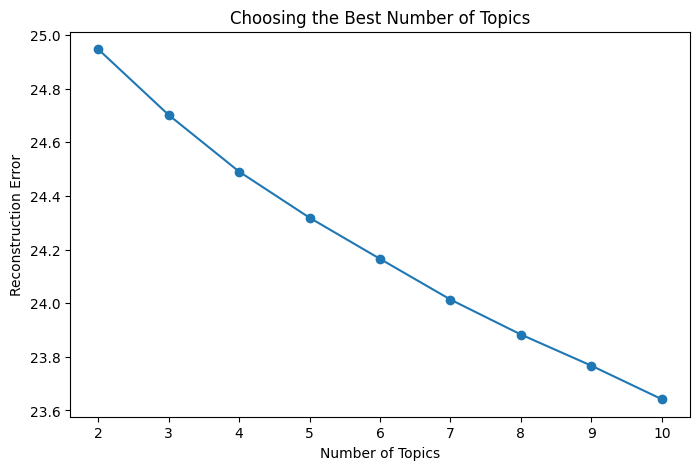

In [40]:
postal_codes_scraper.find_best_num_topics(merged_df, text_col='Unit Description', max_topics=10)

In [24]:
for num_topics in [5, 7, 10]:
    print(f"\n=== Testing with {num_topics} Topics ===")
    topic_extractor = postal_codes_scraper.NMFTopicExtractor(
        text_col='Unit Description',
        num_topics=num_topics,
        max_features=500
    )
    topic_extractor.fit(merged_df)


=== Testing with 5 Topics ===
Topic 1: [('perfect', '0.57'), ('offers', '0.50'), ('convenience', '0.49'), ('home', '0.47'), ('living', '0.40'), ('miss', '0.40'), ('space', '0.39'), ('comfort', '0.38'), ('don', '0.38'), ('vibrant', '0.36'), ('just', '0.36')]
Topic 2: [('building', '0.43'), ('amenities', '0.42'), ('unit', '0.41'), ('concierge', '0.37'), ('pool', '0.37'), ('room', '0.37'), ('party', '0.36'), ('parking', '0.35'), ('condo', '0.34'), ('gym', '0.34'), ('party room', '0.33')]
Topic 3: [('room', '0.38'), ('primary', '0.35'), ('main', '0.33'), ('custom', '0.32'), ('level', '0.32'), ('floor', '0.32'), ('family', '0.31'), ('walk', '0.31'), ('piece', '0.31'), ('closet', '0.30'), ('ensuite', '0.30')]
Topic 4: [('basement', '0.53'), ('home', '0.40'), ('separate', '0.37'), ('entrance', '0.37'), ('detached', '0.36'), ('schools', '0.35'), ('finished', '0.33'), ('lot', '0.32'), ('backyard', '0.31'), ('family', '0.31'), ('finished basement', '0.30')]
Topic 5: [('washer', '0.47'), ('dryer

In [49]:
num_topics = 7

topic_extractor = postal_codes_scraper.NMFTopicExtractor(
    text_col='Unit Description',
    num_topics=num_topics,
    max_features=500
)
topic_extractor.fit(merged_df)

df_transformed = topic_extractor.transform(merged_df)
df_transformed = merged_df[['Unit Description']].join(df_transformed)

print("\n ======================================= \n")
print(df_transformed[[f"Topic_{i+1}" for i in range(num_topics)]].head(10)) # in NMF the weights don't need to sum to 1

Topic 1: [('room', '0.56'), ('level', '0.49'), ('primary', '0.48'), ('main', '0.46'), ('family', '0.46'), ('piece', '0.45'), ('custom', '0.45'), ('walk', '0.43'), ('fireplace', '0.40'), ('closet', '0.40'), ('floor', '0.40')]
Topic 2: [('building', '0.48'), ('amenities', '0.45'), ('pool', '0.41'), ('gym', '0.41'), ('unit', '0.40'), ('party', '0.40'), ('room', '0.39'), ('party room', '0.38'), ('concierge', '0.38'), ('indoor', '0.38'), ('parking', '0.35')]
Topic 3: [('basement', '0.56'), ('home', '0.38'), ('entrance', '0.38'), ('detached', '0.37'), ('finished', '0.36'), ('separate', '0.36'), ('schools', '0.35'), ('finished basement', '0.33'), ('backyard', '0.32'), ('lot', '0.32'), ('garage', '0.30')]
Topic 4: [('perfect', '0.45'), ('home', '0.39'), ('offers', '0.39'), ('convenience', '0.37'), ('comfort', '0.31'), ('living', '0.30'), ('space', '0.30'), ('miss', '0.28'), ('vibrant', '0.27'), ('opportunity', '0.26'), ('ideal', '0.26')]
Topic 5: [('steel', '0.68'), ('stainless', '0.68'), ('st

In [57]:
select_topic = "Topic_5"

df_transformed.nlargest(10, select_topic)[['Unit Description', select_topic]].to_csv("top_listings.csv", index=False)


##### Apply column transformations to create input features

In [17]:
full_pipeline = Pipeline([
    ('geocoder', postal_codes_scraper.PostalCodeGeocoder(postal_code_col='Postal Code Area')),
    ('unit_encoder', postal_codes_scraper.UnitTypeEncoder(unit_type_col='Unit Type')),
    ('bedrooms_encoder', postal_codes_scraper.BedroomSplitter(bedroom_col='Bedrooms')),
    ('topic_extractor', postal_codes_scraper.NMFTopicExtractor(text_col='Unit Description', num_topics=5, max_features=500))
])

print(merged_df.columns)
df_transformed = full_pipeline.fit_transform(merged_df.head(20))

print(df_transformed)
print("\n ===================== \n")
print(df_transformed[['Address', 'Bedrooms', 'Listing URL', 'Main_Bedrooms', 'Extra_Bedrooms']])

Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms',
       'Bathrooms', 'Postal Code', 'Listing URL', 'Bedroom Category',
       'Postal Code Area', 'Sold Days Ago', 'Maintenance Fees',
       'Unit Description'],
      dtype='object')
Topic 1: [('featuring', '0.31'), ('living', '0.27'), ('custom', '0.27'), ('private', '0.25'), ('near', '0.23'), ('home', '0.23'), ('space', '0.21'), ('step outside', '0.21'), ('living area', '0.21'), ('outside', '0.21'), ('gatherings', '0.20')]
Topic 2: [('suite', '0.22'), ('built', '0.19'), ('room', '0.19'), ('building', '0.19'), ('ft', '0.19'), ('walk', '0.18'), ('party', '0.18'), ('tower', '0.18'), ('sq ft', '0.17'), ('sq', '0.17'), ('amenities', '0.17')]
Topic 3: [('pc', '0.42'), ('bdrm', '0.28'), ('pc ensuite', '0.26'), ('main', '0.22'), ('family', '0.21'), ('eat kitchen', '0.20'), ('rec', '0.20'), ('pc bath', '0.20'), ('walk', '0.20'), ('room', '0.20'), ('kitchen', '0.19')]
Topic 4: [('new', '0.23'), ('stove', '0.21'), ('dishwa

*Get a sample of unit descriptions*

In [63]:
# Select a random sample of 5 descriptions
sample_descriptions = merged_df[['Unit Description']].sample(n=5, random_state=42)

# Function to keep only the first 2 sentences
def shorten_text(text, num_sentences=2):
    sentences = text.split(". ")  # Split into sentences
    return ". ".join(sentences[:num_sentences])  # Keep only the first `num_sentences`

# Apply the function to shorten descriptions
sample_descriptions['Short Description'] = sample_descriptions['Unit Description'].apply(lambda x: shorten_text(x))

pd.set_option('display.max_colwidth', None)  # Show full text
print(sample_descriptions[['Short Description']])

                                                                                                                                                                                                                                                                                                                                                                                Short Description
357  Beautiful 1 + 1 Penthouse Corner Unit In Incredible Forest Hill Location! This Sun-Filled Condo Features An Open Concept Floor Plan With Laminate Floors & Soaring Ceilings, Combined Living & Kitchen Area With Walk-Out To Huge Balcony With Gorgeous Views Over The Neighbourhood. Primary Bedroom With Double Closet & 4-Piece Ensuite Bathroom Plus Den/Additional Bedroom/Office Space
259                                                                                                                Welcome To 3420 Kingston Rd Unit 5. Discover This Hidden Gem In Prime Toronto Location! Spacious And Affordable 3

##### Sample code:

In [ ]:
import re
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample short text documents from real estate listings
documents = [
    "Beautiful 1 + 1 Penthouse Corner Unit In Incredible Forest Hill Location! This Sun-Filled Condo Features An Open Concept Floor Plan With Laminate Floors & Soaring Ceilings, Combined Living & Kitchen Area With Walk-Out To Huge Balcony.",
    "Discover This Hidden Gem In Prime Toronto Location! Spacious And Affordable 3+1 Bedroom, 3 Bathroom Condo Townhouse That Has A Practical Layout!",
    "Fully Renovated Unit. Largest Layout in Complex includes 2 Balconies.",
    "In the heart of Etobicoke, you'll find the Nuvo Condos and this thoughtfully laid out 684 Sq Ft unit.",
    "Long live Long Branch! An incredible investment opportunity to live in and rent out, or rent both units! The main floor features a large sun-filled living space, modern kitchen, and two bedrooms.",
    "Do not miss this one! Rare Luxurious 3 Years New Modern Townhouse Near Clark & Bathurst. Approx 2402 Sqft.",
    "This beautiful and bright One Bedroom plus Den unit in The Southampton Residences is the perfect place to call home. Desirably located close to High Park."
]

# Custom function to remove numbers from text
def remove_numbers(text):
    return re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers

# Apply number removal to all descriptions
documents = [remove_numbers(doc) for doc in documents]

# Convert text to TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,3), sublinear_tf=True, min_df=2)
tfidf_matrix = vectorizer.fit_transform(documents)

# Apply NMF with 3 topics
nmf = NMF(n_components=3, random_state=42)
W = nmf.fit_transform(tfidf_matrix)  # Document-topic matrix
H = nmf.components_  # Topic-term matrix

# Display top words per topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    top_words = [feature_names[i] for i in topic.argsort()[:-6 - 1:-1]]  # Top 6 words
    print(f"Topic {topic_idx + 1}: {top_words}")

Topic 1: ['rent', 'long', 'live', 'filled', 'features', 'incredible']
Topic 2: ['unit', 'complex', 'unit largest layout', 'balconies', 'unit largest', 'complex includes']
Topic 3: ['townhouse', 'years new', 'clark', 'years', 'clark bathurst', 'clark bathurst approx']
